# Face Recognition - PubFig83

**D3APL – Aplicações em Ciência de dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 1. Informações Gerais

## 1.1. Conhecendo  o dataset


## 1.2. Atributos:



## 1.3. Objetivo


# 2. Importações
## 2.1 Bibliotecas

In [3]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import os

# Visualização de imagem
import cv2
import matplotlib.pyplot as plt

## 2.2 Datasets

In [4]:
# Path das imagens
dataset_folder = '../Datasets/imgs/'

# Lista de pastas
class_folders = sorted(os.listdir(dataset_folder))
n_classes = len(class_folders)

print(f'Número de Classes: {n_classes}')

Número de Classes: 83


In [5]:
# Dataset de treino
train = pd.read_csv('../Datasets/train.csv')

# Dataset de treino
test = pd.read_csv('../Datasets/test.csv')

print(f'Train: {len(train)}')
print(f'Test: {len(test)}')

Train: 12178
Test: 1660


## 2.3 Preparação dos dados

In [6]:
# Número de amostras por Classe
min_images = 1000
max_images = 0

x = 0
for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    class_img_filenames = os.listdir(full_class_folder)
    images = len(class_img_filenames)
    x += images
    print(f'{class_folder} - Número de imagem : {images}')
    if images < min_images:
        min_images = images
    if images > max_images:
        max_images = images

print(f'\nClasse com menos imagens: {min_images} Imagens')
print(f'Classe com mais imagens: {max_images} Imagens')

Adam Sandler - Número de imagem : 108
Alec Baldwin - Número de imagem : 103
Angelina Jolie - Número de imagem : 214
Anna Kournikova - Número de imagem : 171
Ashton Kutcher - Número de imagem : 101
Avril Lavigne - Número de imagem : 299
Barack Obama - Número de imagem : 268
Ben Affleck - Número de imagem : 117
Beyonce Knowles - Número de imagem : 126
Brad Pitt - Número de imagem : 300
Cameron Diaz - Número de imagem : 246
Cate Blanchett - Número de imagem : 160
Charlize Theron - Número de imagem : 195
Christina Ricci - Número de imagem : 143
Claudia Schiffer - Número de imagem : 122
Clive Owen - Número de imagem : 134
Colin Farrell - Número de imagem : 145
Colin Powell - Número de imagem : 112
Cristiano Ronaldo - Número de imagem : 168
Daniel Craig - Número de imagem : 168
Daniel Radcliffe - Número de imagem : 246
David Beckham - Número de imagem : 187
David Duchovny - Número de imagem : 149
Denise Richards - Número de imagem : 200
Drew Barrymore - Número de imagem : 152
Dustin Hoffman 

In [7]:
# Dataframe com volume de amostras de treino e teste e a proporção entre eles
train_samples = train['image_pathname'].str.split('/', expand=True).loc[:,1].value_counts()
samples = pd.DataFrame(data = train_samples.values, index = train_samples.index, columns = ['Train_samples'])
samples['Test_samples'] = test['image_pathname'].str.split('/', expand=True).loc[:,1].value_counts()
samples['Proportion'] = samples['Test_samples'] / samples['Train_samples']
samples

,Train_samples,Test_samples,Proportion
Miley Cyrus,347,20,0.057637
Lindsay Lohan,334,20,0.059880
Jessica Simpson,280,20,0.071429
Brad Pitt,280,20,0.071429
Avril Lavigne,279,20,0.071685
...,...,...,...
Mariah Carey,82,20,0.243902
Ashton Kutcher,81,20,0.246914
Jack Nicholson,81,20,0.246914
Robert Gates,80,20,0.250000


In [8]:
# Criando uma coluna com as classes nos datasets de treino e test
train['class'] = train.iloc[:,0].str.split('/', expand=True).loc[:,1]
test['class'] = test.iloc[:,0].str.split('/', expand=True).loc[:,1]

In [9]:
train.sample(3)

,image_pathname,class
11675,imgs/Uma Thurman/107.jpg,Uma Thurman
1504,imgs/Brad Pitt/411.jpg,Brad Pitt
5641,imgs/Jennifer Lopez/252.jpg,Jennifer Lopez


In [10]:
test.sample(3)

,image_pathname,class
715,imgs/Hugh Laurie/214.jpg,Hugh Laurie
618,imgs/Gordon Brown/90.jpg,Gordon Brown
1090,imgs/Martha Stewart/58.jpg,Martha Stewart


## 2.4 Tamanho das imagens

In [11]:
img = cv2.imread('../Datasets/' + train.iloc[0]['image_pathname'])
img.shape

(100, 100, 3)

In [12]:
 img.min(), img.max()

(0, 255)

## 2.5 Visualização das imagens

In [13]:
# read an image
def print_image (df, pos):
    img = cv2.imread('../Datasets/' + df.iloc[pos]['image_pathname'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

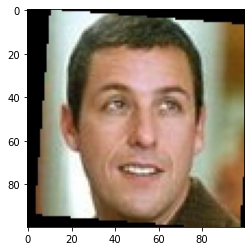

In [14]:
print_image(train, 5)

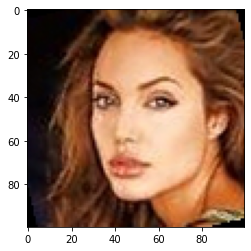

In [15]:
print_image(test, 50)

# 3. Pré-processamento

## 3.1 Dados de validação

In [16]:
from sklearn.model_selection import train_test_split

train_labels = train['class']

train, validation = train_test_split(train, train_size=0.8, stratify=train_labels)

In [17]:
train['class'].value_counts()

Miley Cyrus        277
Lindsay Lohan      267
Brad Pitt          224
Jessica Simpson    224
Avril Lavigne      223
                  ... 
Mariah Carey        66
Ashton Kutcher      65
Jack Nicholson      65
Robert Gates        64
Dustin Hoffman      64
Name: class, Length: 83, dtype: int64

In [18]:
validation['class'].value_counts()

Miley Cyrus        70
Lindsay Lohan      67
Jessica Simpson    56
Avril Lavigne      56
Brad Pitt          56
                   ..
Robert Gates       16
Mariah Carey       16
Jack Nicholson     16
Ashton Kutcher     16
Dustin Hoffman     16
Name: class, Length: 83, dtype: int64

In [19]:
import cv2
from sklearn.preprocessing import LabelEncoder

def preprocess_dataset(dataset_df, label_encoder: LabelEncoder):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate('../Datasets/' + dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % 1000 == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    X = np.array(image_list)
    
    # feature scaling
    X = X / 255.0
    
    # encoding the classes
    y = label_encoder.fit_transform(dataset_df['class'])
    
    return X, y

In [20]:
# training a Label Encoder from the train set
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train['class'])

label_encoder.classes_

array(['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie',
       'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne',
       'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt',
       'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron',
       'Christina Ricci', 'Claudia Schiffer', 'Clive Owen',
       'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo',
       'Daniel Craig', 'Daniel Radcliffe', 'David Beckham',
       'David Duchovny', 'Denise Richards', 'Drew Barrymore',
       'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill',
       'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry',
       'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson',
       'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt',
       'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix',
       'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss',
       'Kate Winslet', 'Katherine Heigl', 'Keira Knightley',
       'Kiefer Sutherland', 'Leo

In [21]:
# preprocessing the train set
X_train, y_train = preprocess_dataset(train, label_encoder)

1/9742 - ../Datasets/imgs/Sania Mirza/55.jpg
1001/9742 - ../Datasets/imgs/Hugh Jackman/13.jpg
2001/9742 - ../Datasets/imgs/Denise Richards/43.jpg
3001/9742 - ../Datasets/imgs/Victoria Beckham/222.jpg
4001/9742 - ../Datasets/imgs/Kate Winslet/266.jpg
5001/9742 - ../Datasets/imgs/Tom Cruise/263.jpg
6001/9742 - ../Datasets/imgs/Hugh Laurie/257.jpg
7001/9742 - ../Datasets/imgs/Meryl Streep/218.jpg
8001/9742 - ../Datasets/imgs/Katherine Heigl/135.jpg
9001/9742 - ../Datasets/imgs/Scarlett Johansson/314.jpg


In [22]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (9742, 100, 100, 3)
y_train (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_train.shape: (9742,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



In [23]:
# preprocessing the validation set
X_validation, y_validation = preprocess_dataset(validation, label_encoder)

1/2436 - ../Datasets/imgs/Hugh Laurie/153.jpg
1001/2436 - ../Datasets/imgs/Kate Winslet/340.jpg
2001/2436 - ../Datasets/imgs/Brad Pitt/254.jpg


In [24]:
print(f'X_validation.shape: {X_validation.shape}')
print(f'y_validation (classes): {np.unique(y_validation)}')
print(f'y_validation.shape: {y_validation.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_validation: {X_validation.min()}')
print(f'Max. value of X_validation: {X_validation.max()}\n')

X_validation.shape: (2436, 100, 100, 3)
y_validation (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_validation.shape: (2436,)
Min. value of X_validation: 0.0
Max. value of X_validation: 1.0



In [25]:
# preprocessing the test set
X_test, y_test = preprocess_dataset(test, label_encoder)

1/1660 - ../Datasets/imgs/Adam Sandler/34.jpg
1001/1660 - ../Datasets/imgs/Kiefer Sutherland/40.jpg


In [26]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}\n')

X_test.shape: (1660, 100, 100, 3)
y_test (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_test.shape: (1660,)
Min. value of X_test: 0.0
Max. value of X_test: 1.0



## 3.1 Balanceamento de classes

In [27]:
n_samples = np.bincount(y_train)
classes = np.nonzero(y_train)[0]

samples_per_class = list(zip(classes, n_samples))
samples_per_class[:5]

[(0, 70), (1, 66), (2, 155), (3, 121), (4, 65)]

In [28]:
max_samples = max(samples_per_class, key = lambda i: i[1])
max_samples

(60, 277)

A classe 60 possui a maior quantidade de amostras, com 277.

In [29]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

new_images = []
new_classes = []

desired_samples = max_samples[1]
# For each class
for (cls, n_samples) in samples_per_class:
    # Indexes of samples of current class
    cls_indexes = np.where(y_train == cls)[0]

    # For each missing sample until reach desired samples
    for i in range(desired_samples - n_samples):
        # Get a random image that belongs to the current class
        idx = np.random.choice(cls_indexes)
        img = X_train[idx]
        img = np.expand_dims(img, axis=0)
        
        # Create a new image
        with tf.device('/cpu:0'):
            data_augmentation = Sequential([
                RandomFlip("horizontal"),
                RandomRotation(factor=0.1)
            ])
            augmented = data_augmentation(img)
            new_images.append(augmented[0])
            new_classes.append(cls)

2022-06-15 22:32:36.954042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 22:32:36.954141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


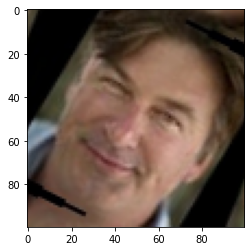

In [34]:
plt.imshow(new_images[207])

In [55]:
arr_new_images = np.array(new_images)
X_train = np.append(X_train, arr_new_images, axis=0)
y_train = np.append(y_train, new_classes)

In [56]:
X_train.shape

(22991, 100, 100, 3)

In [57]:
y_train.shape

(22991,)

In [150]:
import os

out_dir = '../Datasets/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
train.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)
#np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
#np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

# 4. Modelos

In [187]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

def build_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Flatten(),

        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [188]:
input_shape = X_train.shape[1:]

model = build_cnn(input_shape, n_classes)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [189]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 15488)             0         
                                                                 
 dense_16 (Dense)            (None, 256)              

In [190]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [191]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-14 20:55:37.760543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 4.3736 - accuracy: 0.0245

2022-06-14 20:55:45.442535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 9s 36ms/step - loss: 4.3736 - accuracy: 0.0245 - val_loss: 4.3478 - val_accuracy: 0.0276
Epoch 2/100
195/195 [==============================] - 6s 32ms/step - loss: 4.3054 - accuracy: 0.0430 - val_loss: 4.2814 - val_accuracy: 0.0481
Epoch 3/100
195/195 [==============================] - 6s 32ms/step - loss: 4.2145 - accuracy: 0.0605 - val_loss: 4.1999 - val_accuracy: 0.0545
Epoch 4/100
195/195 [==============================] - 6s 32ms/step - loss: 4.0719 - accuracy: 0.0739 - val_loss: 4.0974 - val_accuracy: 0.0680
Epoch 5/100
195/195 [==============================] - 6s 33ms/step - loss: 3.9110 - accuracy: 0.0950 - val_loss: 4.0404 - val_accuracy: 0.0744
Epoch 6/100
195/195 [==============================] - 6s 33ms/step - loss: 3.7213 - accuracy: 0.1243 - val_loss: 3.8498 - val_accuracy: 0.0956
Epoch 7/100
195/195 [==============================] - 6s 33ms/step - loss: 3.5048 - accuracy: 0.1673 - val_loss: 3.8628 - val_accuracy: 0.1084
Epoc

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

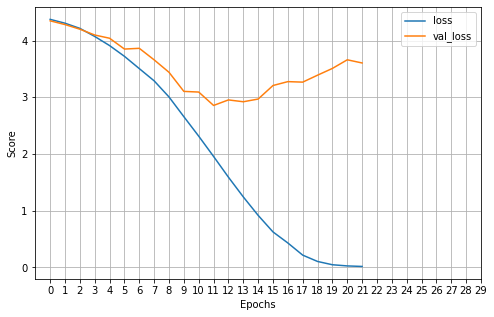

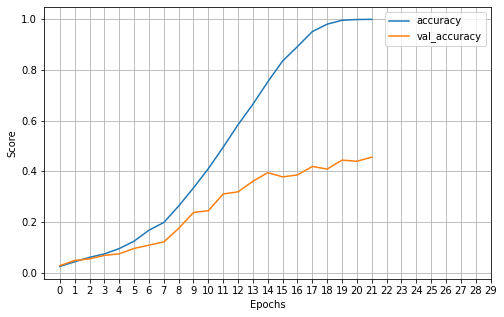

In [195]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [196]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 1s 14ms/step - loss: 3.0224 - accuracy: 0.2723


[3.0224242210388184, 0.2722891569137573]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [197]:
y_test_proba = model.predict(X_test)
y_test_proba

 8/52 [===>..........................] - ETA: 0s

2022-06-14 20:59:52.933301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 1s 13ms/step


array([[2.40835622e-01, 4.68402402e-03, 4.53140028e-03, ...,
        3.89058166e-03, 9.82501917e-03, 4.03682323e-04],
       [2.40152497e-02, 2.04448495e-02, 6.45359233e-02, ...,
        6.28657732e-03, 3.19031155e-04, 9.75469779e-03],
       [3.08604181e-01, 4.37456090e-03, 1.40626437e-03, ...,
        5.66703457e-05, 5.00988208e-05, 3.93579295e-03],
       ...,
       [4.27874038e-04, 1.14224304e-03, 2.64154223e-04, ...,
        5.47717558e-04, 3.30808216e-05, 1.43525422e-01],
       [1.02945073e-02, 4.82566655e-03, 1.52993435e-03, ...,
        2.75484839e-04, 1.27076125e-02, 4.28763665e-02],
       [8.97973310e-04, 6.15978497e-05, 2.01189003e-04, ...,
        3.39879887e-04, 4.26878751e-06, 4.46056455e-01]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [198]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([ 0, 16,  9, ...,  4, 34, 82])

In [199]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       1.00      0.05      0.10        20
        Alec Baldwin       0.40      0.10      0.16        20
      Angelina Jolie       0.67      0.30      0.41        20
     Anna Kournikova       0.25      0.05      0.08        20
      Ashton Kutcher       0.67      0.20      0.31        20
       Avril Lavigne       0.26      0.40      0.31        20
        Barack Obama       0.47      0.35      0.40        20
         Ben Affleck       0.18      0.35      0.24        20
     Beyonce Knowles       0.71      0.25      0.37        20
           Brad Pitt       0.09      0.40      0.15        20
        Cameron Diaz       0.18      0.25      0.21        20
      Cate Blanchett       0.33      0.05      0.09        20
     Charlize Theron       0.00      0.00      0.00        20
     Christina Ricci       0.67      0.10      0.17        20
    Claudia Schiffer       0.46      0.30      0.36        20
       

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

--------------

In [208]:
# https://keras.io/api/applications/vgg/
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

from tensorflow.keras.applications import VGG16

base_model = VGG16(include_top=None,   # we will ignore the top layers that consists of the MLP classifier of VGG16
                   weights="imagenet", # we will use the weights learned for the ImageNet dataset
                   input_shape=X_train.shape[1:])  # let's consider a smaller resolution than the original paper due to lack of memory


# freeze the base model weights ==> these weights won't be updated during training
# i.e., the weights of all layers from the base model are not updated
base_model.trainable = False

In [209]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

Note that **there are no Trainable parameters**.

<br/>

**Plugging a Fully-connected network classifier into the base model**

In [210]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


model = Sequential([
    # our base model
    base_model,
    
    Flatten(),
    
    # FC classifier
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    
    Dense(10, activation='softmax')
])

In [211]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 4608)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               589952    
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 10)                650       
                                                                 
Total params: 15,313,546
Trainable params: 598,858
Non-trainable params: 14,714,688
_________________________________________________________________


Although our **model** has _a lot of parameters_, there is a **smaller** number of **trained parameters**.

In [212]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 2.3 Training with Early Stopping

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [213]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [215]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-14 21:02:50.205095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


244/244 [==============================] - ETA: 0s - loss: 4.9165 - accuracy: 0.0145

2022-06-14 21:03:23.452511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


244/244 [==============================] - 41s 165ms/step - loss: 4.9165 - accuracy: 0.0145 - val_loss: 13.2926 - val_accuracy: 0.0231
Epoch 2/100
244/244 [==============================] - 37s 150ms/step - loss: 50.3816 - accuracy: 0.0144 - val_loss: 90.8992 - val_accuracy: 0.0231
Epoch 3/100
244/244 [==============================] - 37s 153ms/step - loss: 154.3661 - accuracy: 0.0139 - val_loss: 367.4898 - val_accuracy: 0.0205
Epoch 4/100
244/244 [==============================] - 40s 165ms/step - loss: 308.1139 - accuracy: 0.0128 - val_loss: 290.9089 - val_accuracy: 0.0067
Epoch 5/100
244/244 [==============================] - 41s 169ms/step - loss: 492.6900 - accuracy: 0.0151 - val_loss: 639.9091 - val_accuracy: 0.0231
Epoch 6/100
244/244 [==============================] - 41s 169ms/step - loss: 713.2940 - accuracy: 0.0137 - val_loss: 803.6475 - val_accuracy: 0.0087
Epoch 7/100
244/244 [==============================] - 41s 168ms/step - loss: 1021.3368 - accuracy: 0.0133 - val_loss

#### **Visualizing the training history**

In [216]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

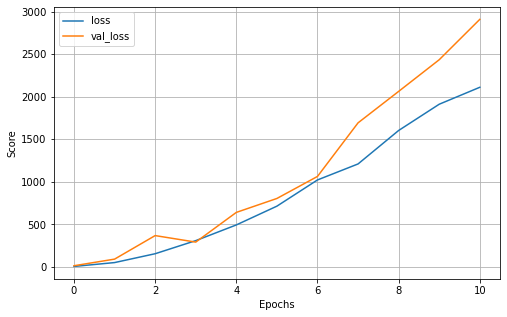

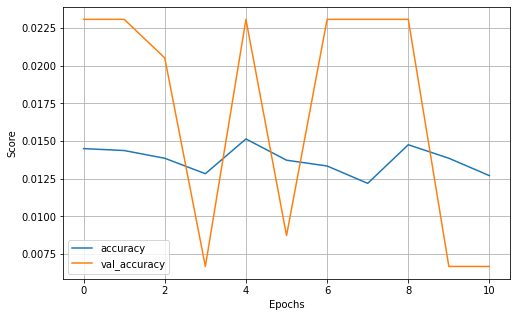

In [217]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [218]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 6s 120ms/step - loss: 15.6560 - accuracy: 0.0120


[15.655982971191406, 0.012048193253576756]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [219]:
y_test_proba = model.predict(X_test)
y_test_proba

 2/52 [>.............................] - ETA: 3s

2022-06-14 21:10:42.181088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 6s 119ms/step


array([[0.0000000e+00, 0.0000000e+00, 7.9537980e-30, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.3031112e-32, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.4716429e-36, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 4.6976524e-38, 9.3746287e-28, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.1662308e-31, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.7069982e-29, 8.7118759e-22, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [220]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([9, 9, 9, ..., 9, 9, 9])

In [221]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       0.00      0.00      0.00        20
        Alec Baldwin       0.00      0.00      0.00        20
      Angelina Jolie       0.00      0.00      0.00        20
     Anna Kournikova       0.00      0.00      0.00        20
      Ashton Kutcher       0.00      0.00      0.00        20
       Avril Lavigne       0.00      0.00      0.00        20
        Barack Obama       0.00      0.00      0.00        20
         Ben Affleck       0.00      0.00      0.00        20
     Beyonce Knowles       0.00      0.00      0.00        20
           Brad Pitt       0.01      1.00      0.02        20
        Cameron Diaz       0.00      0.00      0.00        20
      Cate Blanchett       0.00      0.00      0.00        20
     Charlize Theron       0.00      0.00      0.00        20
     Christina Ricci       0.00      0.00      0.00        20
    Claudia Schiffer       0.00      0.00      0.00        20
       

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

------

**VGG16 (with pre-trained weights) for feature extraction**

In [222]:
# https://keras.io/api/applications/vgg/
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=None,   # we will ignore the top layers that consists of the MLP classifier of VGG16
              weights="imagenet", # we will use the weights learned for the ImageNet dataset
              input_shape=(100, 100, 3))  # let's consider a smaller resolution than the original paper due to lack of memory

# unnecessary because we will not train these network
vgg16.trainable = False

In [223]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten

feat_extractor = Sequential([
    vgg16,
    Flatten()
])

In [224]:
feat_extractor.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [225]:
X_train = feat_extractor.predict(X_train)

  1/244 [..............................] - ETA: 59s

2022-06-14 21:12:12.478803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


244/244 [==============================] - 28s 113ms/step


In [226]:
X_test = feat_extractor.predict(X_test)

52/52 [==============================] - 6s 124ms/step


In [227]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')

print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (7793, 4608)
y_train.shape: (7793,)

X_test.shape: (1660, 4608)
y_test.shape: (1660,)


### 2.4 Training a Linear SVM from the extracted Features

In [228]:
from sklearn.svm import LinearSVC

In [229]:
svm = LinearSVC(C=0.01, verbose=100)

In [230]:
svm.fit(X_train, y_train)

[LibLinear]
systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

.....................*.
optimization finished, #iter = 220
Objective value = -0.544397
nSV = 388
.....................*.*
optimization finished, #iter = 221
Objective value = -0.525135
nSV = 418
..........................**
optimization finished, #iter = 267
Objective value = -1.770499
nSV = 911
............................**
optimization finished, #iter = 288
Objective value = -1.504717
nSV = 847
......................**
optimization finished, #iter = 227
Objective value = -0.739582
nSV = 545
.........................*
optimization finished, #iter = 252
Objective value = -1.486154
nSV = 657
.......................**.
optimization finished, #iter = 240
Objective value = -1.140281
nSV = 595
........................*
optimization finished, #iter = 241
Objective value = -0.834065
nSV = 540
..........................**
optimization finished, #iter = 267
Objective value = -0.932655
nSV = 584
............................**
optimizatio

LinearSVC(C=0.01, verbose=100)

#### **Class Prediction**

In [231]:
y_test_pred = svm.predict(X_test)
y_test_pred

array([ 0,  0,  0, ..., 82, 82, 82])

In [232]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       0.76      0.65      0.70        20
        Alec Baldwin       0.79      0.55      0.65        20
      Angelina Jolie       0.35      0.40      0.37        20
     Anna Kournikova       0.53      0.45      0.49        20
      Ashton Kutcher       1.00      0.30      0.46        20
       Avril Lavigne       0.41      0.55      0.47        20
        Barack Obama       0.57      0.80      0.67        20
         Ben Affleck       0.80      0.40      0.53        20
     Beyonce Knowles       0.50      0.30      0.37        20
           Brad Pitt       0.18      0.35      0.24        20
        Cameron Diaz       0.50      0.55      0.52        20
      Cate Blanchett       0.24      0.20      0.22        20
     Charlize Theron       0.30      0.30      0.30        20
     Christina Ricci       0.70      0.35      0.47        20
    Claudia Schiffer       0.85      0.55      0.67        20
       